/data/users2/jwardell1/undersampling-project/OULU/pkl-files/FBIRN/11-25/rwp


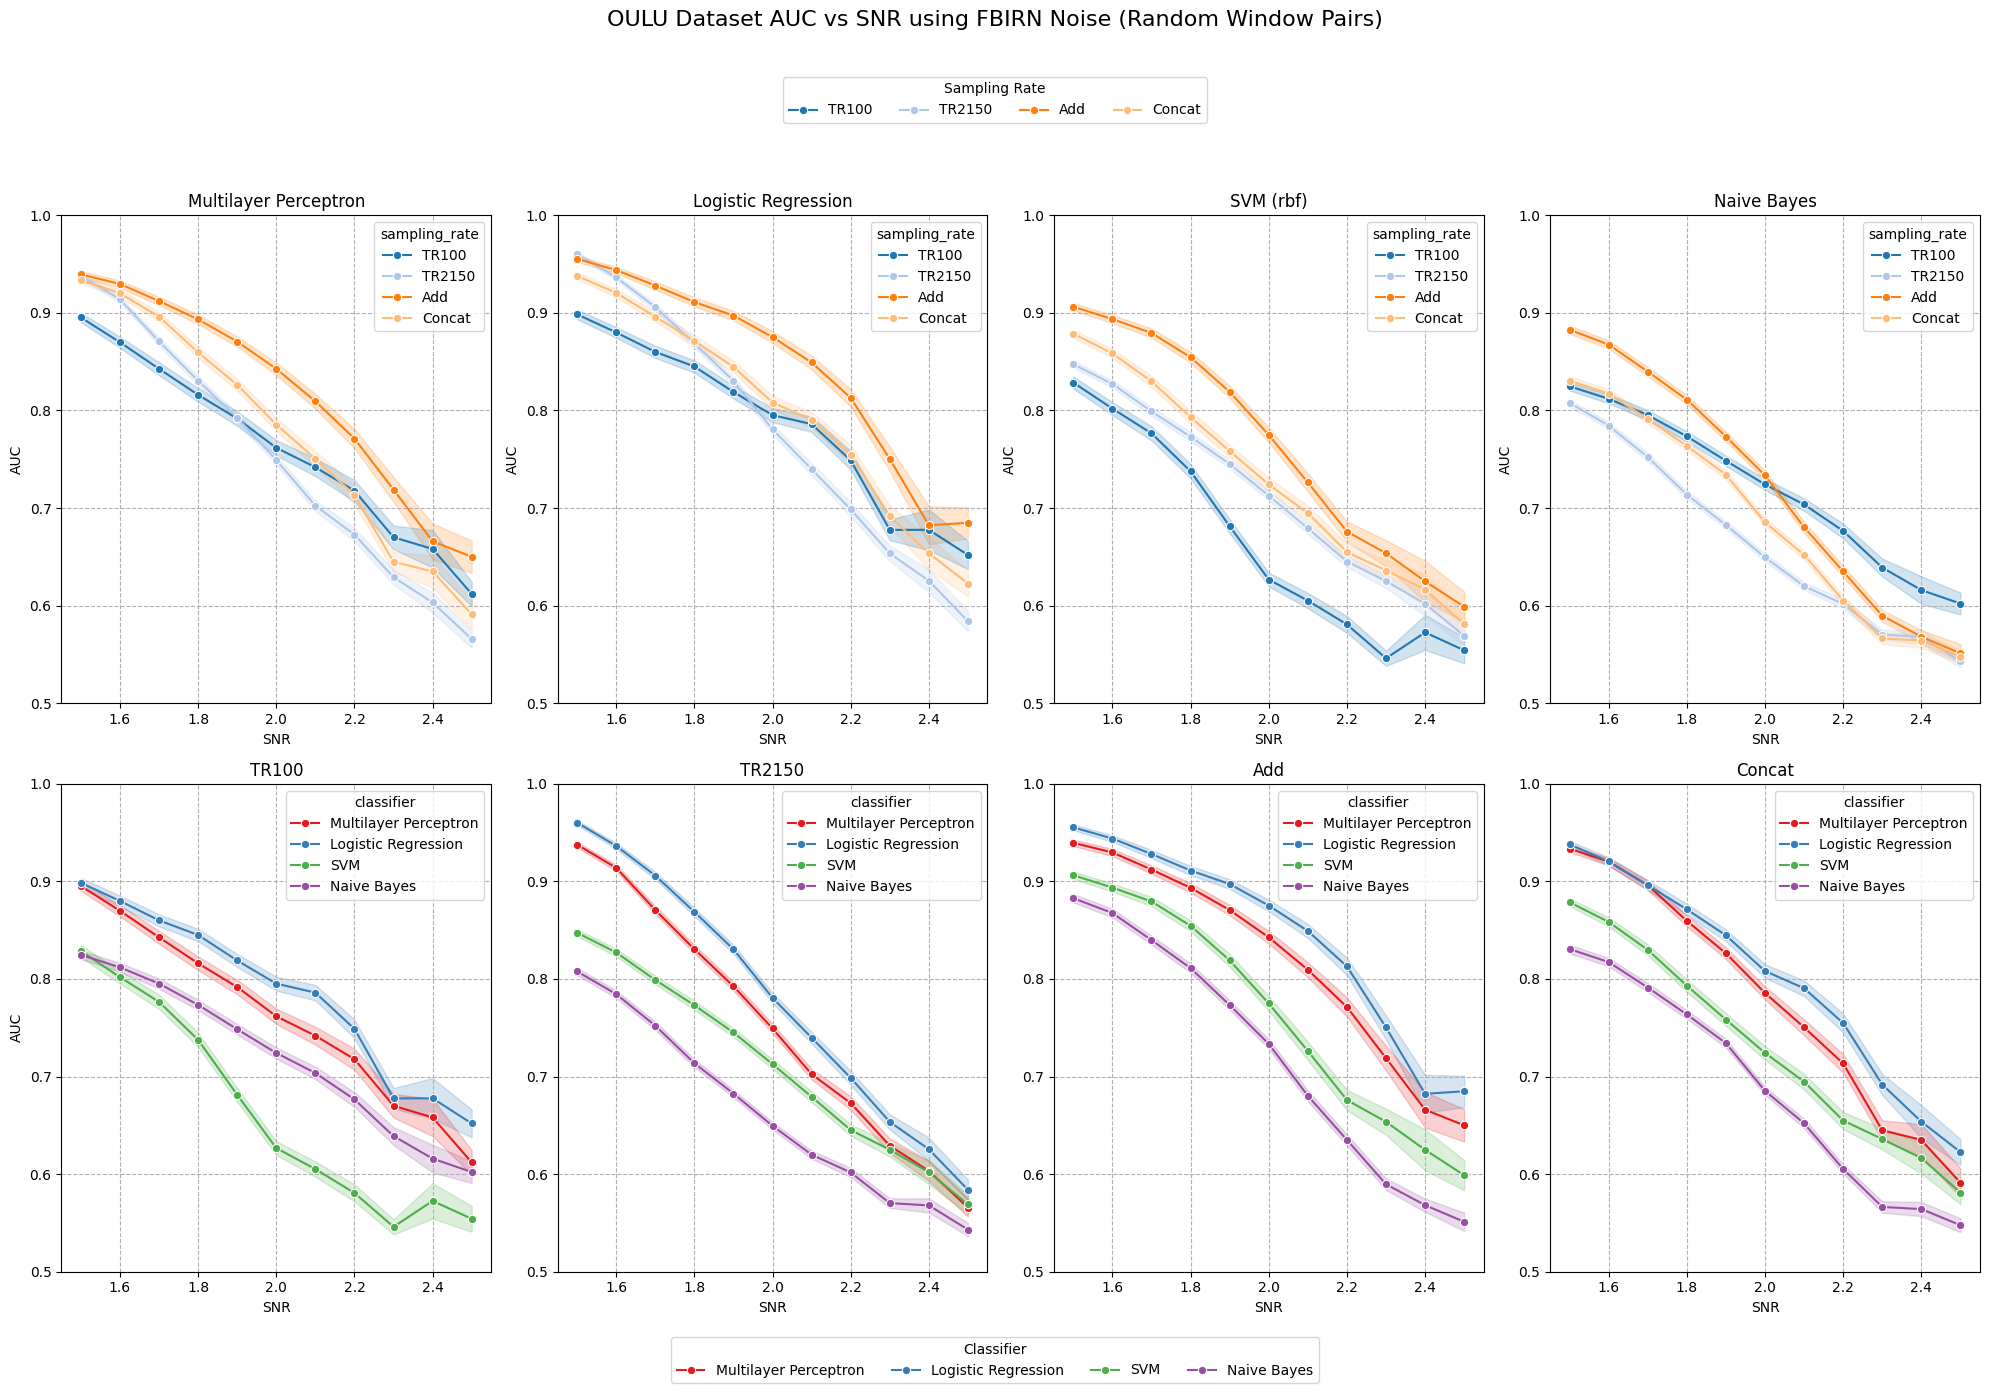

In [9]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np


signal_dataset = 'oulu'
noise_dataset = 'fbirn'

plot_all = False

kernel_type = 'rbf'

date = '11-25'

window_pairs = True

optuna = False

def plot(noise_dataset, signal_dataset, kernel_type, plot_no, optuna):

    # Define the directory for the current undersampling rate
    pkl_dir = f'/data/users2/jwardell1/undersampling-project/{signal_dataset.upper()}/pkl-files/{noise_dataset.upper()}/optuna/{date}' if optuna \
        else f'/data/users2/jwardell1/undersampling-project/{signal_dataset.upper()}/pkl-files/{noise_dataset.upper()}/{date}'
    
    if window_pairs:
        pkl_dir =  f'/data/users2/jwardell1/undersampling-project/{signal_dataset.upper()}/pkl-files/{noise_dataset.upper()}/{date}/rwp'
    
    print(pkl_dir)




    # Read and concatenate sr1 data
    joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
    joined_list = glob.glob(joined_files)
    sr1 = pd.concat(
        (pd.read_pickle(file).assign(
            sampling_rate='sr1',
            subject_id=file.split('_')[5].split('.')[0]
        ) for file in joined_list),
        ignore_index=True
    )

    # Read and concatenate sr2 data
    joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
    joined_list = glob.glob(joined_files)
    sr2 = pd.concat(
        (pd.read_pickle(file).assign(
            sampling_rate='sr2',
            subject_id=file.split('_')[5].split('.')[0]
        ) for file in joined_list),
        ignore_index=True
    )

    # Read and concatenate concat data
    joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
    joined_list = glob.glob(joined_files)
    concat = pd.concat(
        (pd.read_pickle(file).assign(
            sampling_rate='concat',
            subject_id=file.split('_')[5].split('.')[0]
        ) for file in joined_list),
        ignore_index=True
    )


    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'add_*.pkl')
    joined_list = glob.glob(joined_files)
    add = pd.concat(
        (pd.read_pickle(file).assign(
            sampling_rate='add',
            subject_id=file.split('_')[5].split('.')[0]
        ) for file in joined_list),
        ignore_index=True
    )

    # Concatenate all dataframes
    if optuna:
        result_df = pd.concat([sr1, sr2, concat, add], ignore_index=True)
        result_df = result_df.rename(columns={'roc': 'auc'})

        result_df['classifier'] = result_df['classifier'].replace('lr', 'Logistic Regression')
        result_df['classifier'] = result_df['classifier'].replace('mlp', 'Multilayer Perceptron')
        result_df['classifier'] = result_df['classifier'].replace('svm', 'SVM')
        result_df['classifier'] = result_df['classifier'].replace('nb', 'Naive Bayes')
    else:
        all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)
        
    

    if not optuna:
        # Function to split each row into multiple rows based on cross-validation index
        def split_row(row):
            new_rows = []
            for cv_ix, auc in enumerate(row['test_scores']):
                new_row = row.copy()
                new_row['auc'] = auc
                new_row['cv_ix'] = cv_ix
                new_rows.append(new_row)
            return pd.DataFrame(new_rows)


        all_data = all_data.dropna(subset=['test_scores'])

        # Apply the split_row function to each row of the dataframe and concatenate the results
        result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

        # Drop the original 'test_scores' column as it's no longer needed
        result_df.drop('test_scores', axis=1, inplace=True)



        result_df = result_df[['snr', 'cv_ix', 'auc', 'sampling_rate', 'noise_no', 'classifier']]# 'graph_no', 'classifier']]
    


    result_df['sampling_rate'] = result_df['sampling_rate'].replace('add', 'Add')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('concat', 'Concat')
    if signal_dataset == 'simulation':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'TR2200')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'TR2600')

    if signal_dataset == 'oulu':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'TR100')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'TR2150')

    if signal_dataset == 'hcp':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'SR1')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'SR2')

    
    


    ###########################################################################################################################

    grouped_classifiers = result_df.groupby('classifier')

    classifier_dfs = {}
    for classifier, group_df in grouped_classifiers:
        classifier_dfs[classifier] = group_df.copy()

    mlp_df = classifier_dfs.get('Multilayer Perceptron', pd.DataFrame())
    lr_df = classifier_dfs.get('Logistic Regression', pd.DataFrame())
    svm_df = classifier_dfs.get('SVM', pd.DataFrame())
    nb_df = classifier_dfs.get('Naive Bayes', pd.DataFrame())

    if signal_dataset == 'simulation':
        tr1 = 'TR2200'
        tr2 = 'TR2600'

    if signal_dataset == 'oulu':        
        tr1 = 'TR100'
        tr2 = 'TR2150'

    if signal_dataset == 'hcp':
        tr1 = 'SR1'
        tr2 = 'SR2'

    dfs = [mlp_df, lr_df, svm_df, nb_df]
    classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
    
    sampling_rates = [tr1, tr2, 'Add', 'Concat']
    hue_order = sampling_rates
    palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

    # Combine all dataframes into one dataframe for plotting
    combined_df = pd.concat(dfs)
    snr_levels = [1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]



    # Define your variables
    x = "snr"
    y = "auc"
    hue = "sampling_rate"
    order = snr_levels

    # Create the figure and the axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    # Collect y-limits for determining the common range
    all_y_vals = []

    # Plot the first row with sampling_rate as hue
    for i, classifier in enumerate(classifiers):
        # Filter the data for the current classifier
        data_filtered = combined_df[combined_df['classifier'] == classifier]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, hue]).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
            palette=palette, marker='o', ax=axes[0, i]
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby(hue):
            color = palette[key]
            axes[0, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        if classifier == 'SVM':
            axes[0, i].set_title(f'{classifier} ({kernel_type})')
        else:
            axes[0, i].set_title(f'{classifier}')
        axes[0, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[0, i].set_xlabel('SNR')
        axes[0, i].set_ylabel('AUC')


    # Adjust hue_order and palette for the second row
    hue_order = classifiers
    classifier_palette = sns.color_palette("Set1", len(classifiers))
    palette = {item: classifier_palette[i] for i, item in enumerate(classifiers)}

    # Plot the second row with classifier as hue
    for i, sampling_rate in enumerate(sampling_rates):
        # Filter the data for the current sampling rate
        data_filtered = combined_df[combined_df['sampling_rate'] == sampling_rate]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, 'classifier']).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue='classifier', hue_order=hue_order,
            palette=palette, marker='o', ax=axes[1, i]#, errorbar='sd'
        )
        

        # Add error bands manually
        for key, grp in summary_df.groupby('classifier'):
            color = palette[key]
            axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        # Collect y-values
        all_y_vals.extend(data_filtered[y].values)
        
        axes[1, i].set_title(f'{sampling_rate}')
        axes[1, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[1, i].set_xlabel('SNR')
        if i == 0:
            axes[1, i].set_ylabel('AUC')
        else:
            axes[1, i].set_ylabel('')
    
    



    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add a super title
    #fig.suptitle(f"Finnish Dataset AUC vs SNR using FBIRN subject {subID} Noise", fontsize=16, y=1.10)
    plt_name = f"{signal_dataset.upper()} Dataset AUC vs SNR using {noise_dataset.upper()} Noise" if not window_pairs \
        else f"{signal_dataset.upper()} Dataset AUC vs SNR using {noise_dataset.upper()} Noise (Random Window Pairs)"
    fig.suptitle(plt_name, fontsize=16, y=1.10)

    # Add grid
    for ax_row in axes:
        for ax in ax_row:
            ax.grid(True, which='both', axis='both', linestyle='--')

    # Add legends
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(sampling_rates), title='Sampling Rate', bbox_to_anchor=(0.5, 1.05))

    handles, labels = axes[1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(classifiers), title='Classifier', bbox_to_anchor=(0.5, -0.05))
    #plt.savefig(f'../results/{signal_dataset}_{noise_dataset}_{kernel_type}.png')

    plt.show()
    return summary_df

if plot_all:
    plot_no = 0
    signal_datasets = ['oulu', 'hcp']#, 'simulation']
    noise_datasets = ['fbirn', 'FBIRN']#, 'var']
    kernels = ['rbf']#, 'linear']

    for signal_dataset in signal_datasets:
        for noise_dataset in noise_datasets:
            for kernel_type in kernels:
                try:
                    summary_df = plot(noise_dataset, signal_dataset, kernel_type, plot_no, optuna)
                    plot_no += 1
                except ValueError as e:
                    pass
                    #print(f'error poltting {signal_dataset} {noise_dataset} {kernel_type} sklearn {sklearn}')

else:
    summary_df = plot(noise_dataset, signal_dataset, kernel_type, 0, optuna)
